<a href="https://colab.research.google.com/github/gracialukelo/pytorch/blob/main/Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [87]:
# Definiere das Modell für das Iris-Datenset
class IrisModel(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super(IrisModel, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [88]:
# Trainingsfunktion für das Modell
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs, save_path='best_model.pth'):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for x, y in train_loader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct_predictions += (predicted == y).sum().item()
            total_samples += y.size(0)
            running_loss += loss.item()

        accuracy = correct_predictions / total_samples * 100


        # Validierung nach jeder Epoche
        val_loss, val_accuracy = evaluate(model, criterion, val_loader)
        val_losses.append(val_loss)

        # Speichern des Modells, wenn die Genauigkeit über 90% liegt
        if val_accuracy > 90:
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with Validation Accuracy: {val_accuracy:.2f}%")
            break

        # Ausgabe von Verlust und Genauigkeit
        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch+1}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return losses, val_losses

In [89]:
# Evaluierungsfunktion für das Modell (nur auf Validierungsdaten)
def evaluate(model, criterion, val_loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    accuracy = correct / total * 100
    avg_loss = running_loss / len(val_loader)
    return avg_loss, accuracy

In [90]:
# Funktion zum Laden und Vorhersagen mit dem gespeicherten Modell
def load_and_predict(model, input_data, load_path='best_model.pth'):
    model.load_state_dict(torch.load(load_path))
    model.eval()
    with torch.no_grad():
        output = model(input_data)
        _, prediction = output.max(1)
    return prediction

In [91]:
# Funktion zum Abrufen der Daten
def get_data(url):
    my_df = pd.read_csv(url)
    return my_df

# Zielspalte in Ganzzahlen konvertieren
def str_to_int(my_df):
    my_df["variety"] = my_df["variety"].replace("Setosa", 0)
    my_df['variety'] = my_df['variety'].replace('Versicolor', 1)
    my_df['variety'] = my_df['variety'].replace('Virginica', 2)
    return my_df

# Trainings- und Validierungsdaten aufteilen
def train_val_test_split(my_df):
    X = my_df.drop('variety', axis=1).values
    y = my_df['variety'].values
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=41)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=41)

    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)
    y_test = torch.LongTensor(y_test)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [92]:
# Hauptteil
url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
df = get_data(url)
df = str_to_int(df)

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

<ipython-input-91-1904c86db0cd>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['variety'] = my_df['variety'].replace('Virginica', 2)


In [93]:
torch.manual_seed(41)
model = IrisModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
train_losses, val_losses = train(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Model saved with Validation Accuracy: 100.00%


In [94]:
# Endgültige Evaluierung mit Testdaten
test_loss, test_accuracy = evaluate(model, criterion, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.4383, Test Accuracy: 91.30%


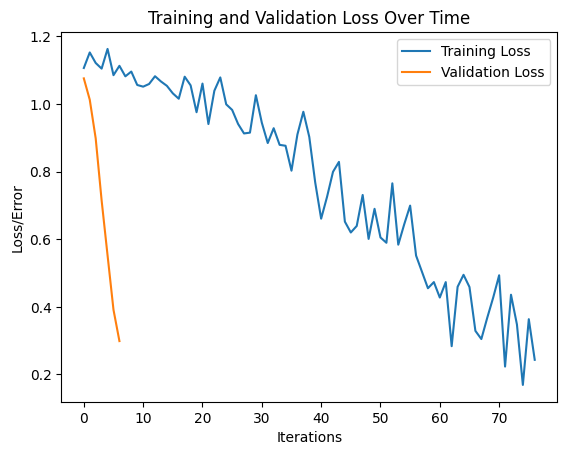

In [95]:
# Plot der Trainings- und Validierungsverluste
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.ylabel("Loss/Error")
plt.xlabel("Iterations")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.show()

In [85]:
# Modell laden und Vorhersage durchführen
sample_input = X_test[:5]  # Beispiel-Daten zum Testen
predictions = load_and_predict(model, sample_input)
print("Sample Predictions:", predictions)


Sample Predictions: tensor([0, 2, 2, 2, 1])


<ipython-input-79-5b55b9c1f30e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))
